In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
using CSV
using DataFrames
using Distributions
using HTTP
import ForneyLab.dot2svg
@everywhere using Mamba
# using Mamba
using Plots

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
[ Info: Loading DataFrames support into Gadfly.jl


# 1 ベイズ推論の考え方
## 1.4 例題 : メッセージ数に変化はあるのか？
メッセージ受信数が時間が経つにつれて変化するかどうかを調べる

In [3]:
r = HTTP.request("GET", "https://git.io/vXTVC");
count_data = CSV.read(IOBuffer(r.body), header=["messages"])
disallowmissing!(count_data)

74×1 DataFrame
│ Row │ messages │
│     │ Float64  │
├─────┼──────────┤
│ 1   │ 13.0     │
│ 2   │ 24.0     │
│ 3   │ 8.0      │
│ 4   │ 24.0     │
│ 5   │ 7.0      │
│ 6   │ 35.0     │
│ 7   │ 14.0     │
│ 8   │ 11.0     │
│ 9   │ 15.0     │
│ 10  │ 11.0     │
⋮
│ 64  │ 31.0     │
│ 65  │ 30.0     │
│ 66  │ 13.0     │
│ 67  │ 27.0     │
│ 68  │ 0.0      │
│ 69  │ 39.0     │
│ 70  │ 37.0     │
│ 71  │ 5.0      │
│ 72  │ 14.0     │
│ 73  │ 13.0     │
│ 74  │ 22.0     │

In [4]:
N = length(count_data.messages)

74

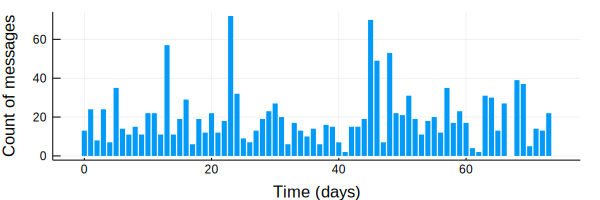

In [5]:
bar(0:N-1, count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")

$i$日目のメッセージを$C_i$とするとき、
\begin{align}
C_i \sim \text{Poisson}(\lambda)
\end{align}
とする.
### まずは一番な単純なモデル
\begin{align}
\lambda \sim \text{Exp}(\alpha)
\end{align}
のモデルを作ってみる。$\alpha$は計数データの平均の逆数とする。Distribution.jlにおけるパラメーターの取り方は、PyMCと異なることに留意。  
https://juliastats.github.io/Distributions.jl/latest/univariate.html#Continuous-Distributions-1

In [6]:
theta = mean(count_data.messages)

19.743243243243242

In [7]:
model0 = Model(
    
    obs = Stochastic(1,
        (ls, N) ->
            UnivariateDistribution[Poisson(ls[i]) for i in 1:N],
        false
    ),
    
    ls = Logical(1, (lambda, N) -> fill(lambda, N), false),
    
    lambda = Stochastic(theta -> Exponential(theta)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
ls:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]


In [8]:
data0 = Dict{Symbol, Any}(
    :obs => count_data.messages,
    :theta => theta,
    :N => N,
)

Dict{Symbol,Any} with 3 entries:
  :N     => 74
  :obs   => [13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0,…
  :theta => 19.7432

In [9]:
inits0 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda => theta,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])
 Dict(:lambda=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0])

In [10]:
scheme0 = [AMWG([:lambda], 1.0)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [11]:
setsamplers!(model0, scheme0)
sim0 = mcmc(model0, data0, inits0, 40000, burnin = 10000, thin = 10, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 3:	Chain 2:   0% [4:30:28 of 4:30:32 remaining]
      From worker 2:	Chain 1:   0% [4:29:57 of 4:30:01 remaining]
      From worker 4:	Chain 3:   0% [4:33:23 of 4:33:27 remaining]
      From worker 2:	Chain 1:  10% [0:00:40 of 0:00:45 remaining]
      From worker 3:	Chain 2:  10% [0:00:41 of 0:00:45 remaining]
      From worker 4:	Chain 3:  10% [0:00:41 of 0:00:45 remaining]
      From worker 3:	Chain 2:  20% [0:00:19 of 0:00:24 remaining]
      From worker 2:	Chain 1:  20% [0:00:19 of 0:00:24 remaining]
      From worker 4:	Chain 3:  20% [0:00:19 of 0:00:24 remaining]
      From worker 3:	Chain 2:  30% [0:00:14 of 0:00:20 remaining]
      From worker 2:	Chain 1:  30% [0:00:14 of 0:00:20 remaining]
      From worker 4:	Chain 3:  30% [0:00:14 of 0:00:20 remaining]
      From worker 2:	Chain 1:  40% [0:00:10 of 0:00:16 remaining]
      From worker 3:	Chain 2:  40% [0:00:10 of 0:00:16 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[20.288; 20.0234; … ; 19.7707; 19.7707]

[19.9277; 18.8589; … ; 20.2813; 20.2452]

[19.8635; 19.8635; … ; 19.7933; 19.6343]

$\lambda$の平均はメッセージ数の平均とほぼ一致。

In [12]:
describe(sim0)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
          Mean       SD       Naive SE     MCSE     ESS
lambda 19.738651 0.52700601 0.005555131 0.00900176 3000

Quantiles:
          2.5%     25.0%     50.0%     75.0%     97.5%  
lambda 18.717697 19.376429 19.742557 20.094138 20.764495



In [13]:
gelmandiag(sim0, mpsrf = true, transform = true)

              PSRF 97.5%
      lambda 1.001 1.001
Multivariate 1.000   NaN



サンプリングの図示。サイズの変え方がわからない・・・

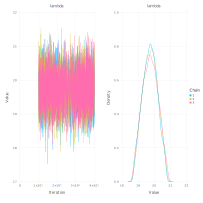

In [14]:
p0 = Mamba.plot(sim0, legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

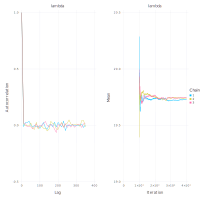

In [15]:
p0 = Mamba.plot(sim0, [:autocor, :mean], legend = true)
Mamba.draw(p0, nrow = 1, ncol = 2)

### 変化はあるか？
ここで、どこかで$\lambda$が大きくなっているか調べるために、
\begin{align}
\lambda_t = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau,\\
\lambda_2 & \text{if}\ t \ge \tau. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\tau & \sim \text{DiscreteUniform}(0,N)
\end{align}
とする。

In [16]:
model1 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, tau, N) -> 
            (out = fill(lambda1, N);
            i = Int64(tau.value) + 1; # Juliaは1-indexingのため
            out[i:end] .= lambda2;
            out),
        ),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    
    tau = Stochastic(N -> DiscreteUniform(0, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
A monitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
tau:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStochastic"
NaN


In [17]:
inits1 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :tau => 1,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:tau=>1,:lambda2=>19.7432)

In [18]:
scheme1 = [AMWG([:lambda1, :lambda2], 1.0), DGS(:tau)]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau])), Const(##238#241(Box(Symbol[:tau])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                                                       

In [19]:
setsamplers!(model1, scheme1)
sim1 = mcmc(model1, data0, inits1, 40000, burnin = 10000, thin = 3, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 2:	Chain 1:   0% [1:31:14 of 1:31:16 remaining]
      From worker 4:	Chain 3:   0% [1:35:02 of 1:35:03 remaining]
      From worker 3:	Chain 2:   0% [1:35:13 of 1:35:14 remaining]
      From worker 4:	Chain 3:  10% [0:01:41 of 0:01:52 remaining]
      From worker 2:	Chain 1:  10% [0:01:42 of 0:01:53 remaining]
      From worker 3:	Chain 2:  10% [0:01:44 of 0:01:56 remaining]
      From worker 4:	Chain 3:  20% [0:01:22 of 0:01:43 remaining]
      From worker 3:	Chain 2:  20% [0:01:24 of 0:01:44 remaining]
      From worker 2:	Chain 1:  20% [0:01:24 of 0:01:45 remaining]
      From worker 4:	Chain 3:  30% [0:01:10 of 0:01:40 remaining]
      From worker 3:	Chain 2:  30% [0:01:11 of 0:01:41 remaining]
      From worker 2:	Chain 1:  30% [0:01:11 of 0:01:41 remaining]
      From worker 4:	Chain 3:  40% [0:00:59 of 0:01:38 remaining]
      From worker 3:	Chain 2:  40% [0:00:60 of 0:01:40 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

[44.0 22.122 … 22.122 22.122; 43.0 22.2711 … 22.2711 22.2711; … ; 45.0 22.0773 … 22.0773 22.0773; 45.0 22.0773 … 22.0773 22.0773]

[45.0 24.9524 … 24.9524 24.9524; 44.0 23.3991 … 23.3991 23.3991; … ; 45.0 23.7761 … 23.7761 23.7761; 45.0 22.8118 … 22.8118 22.8118]

[45.0 22.8095 … 22.8095 22.8095; 45.0 22.4375 … 22.4375 22.4375; … ; 45.0 21.6076 … 21.6076 21.6076; 45.0 23.018 … 23.018 23.018]

In [20]:
describe(sim1)

Iterations = 10010:40000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
              Mean       SD       Naive SE       MCSE        ESS   
       tau 44.278556 1.96039974 0.0206644277 0.0400977461 2390.2832
   lambda2 22.674104 0.96004386 0.0101197509 0.0168633614 3000.0000
   lambda1 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[1] 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[2] 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[3] 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[4] 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[5] 17.759159 0.64695197 0.0068194726 0.0100289602 3000.0000
 lambda[6] 17.760599 0.64445225 0.0067931232 0.0098822357 3000.0000
 lambda[7] 17.760599 0.64445225 0.0067931232 0.0098822357 3000.0000
 lambda[8] 17.760599 0.64445225 0.0067931232 0.0098822357 3000.0000
 lambda[9] 17.761064 0.64488336 0.0067976675 0.0099159653 3000.0

In [21]:
gelmandiag(sim1, mpsrf = true, transform = true)

              PSRF 97.5%
         tau 1.129 1.130
     lambda2 1.024 1.025
     lambda1 1.000 1.001
   lambda[1] 1.000 1.001
   lambda[2] 1.000 1.001
   lambda[3] 1.000 1.001
   lambda[4] 1.000 1.001
   lambda[5] 1.000 1.001
   lambda[6] 1.000 1.001
   lambda[7] 1.000 1.001
   lambda[8] 1.000 1.001
   lambda[9] 1.000 1.001
  lambda[10] 1.000 1.001
  lambda[11] 1.001 1.002
  lambda[12] 1.001 1.002
  lambda[13] 1.001 1.002
  lambda[14] 1.001 1.002
  lambda[15] 1.001 1.002
  lambda[16] 1.001 1.002
  lambda[17] 1.001 1.002
  lambda[18] 1.001 1.002
  lambda[19] 1.001 1.002
  lambda[20] 1.001 1.002
  lambda[21] 1.001 1.002
  lambda[22] 1.001 1.002
  lambda[23] 1.001 1.002
  lambda[24] 1.001 1.002
  lambda[25] 1.001 1.002
  lambda[26] 1.001 1.002
  lambda[27] 1.001 1.002
  lambda[28] 1.001 1.002
  lambda[29] 1.001 1.002
  lambda[30] 1.001 1.002
  lambda[31] 1.001 1.002
  lambda[32] 1.001 1.002
  lambda[33] 1.001 1.002
  lambda[34] 1.001 1.002
  lambda[35] 1.001 1.002
  lambda[36] 1.001 1.002


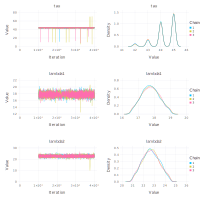

In [22]:
p1 = Mamba.plot(sim1[:, [:tau, :lambda1, :lambda2], :], legend = true)
Mamba.draw(p1, nrow = 3, ncol = 2)

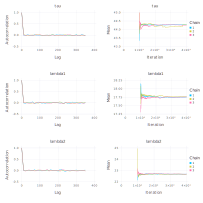

In [23]:
p1 = Mamba.plot(sim1[:, [:tau, :lambda1, :lambda2], :], [:autocor, :mean], legend = true)
Mamba.draw(p1, nrow = 3, ncol = 2)

$\tau$のヒストグラムを表示する

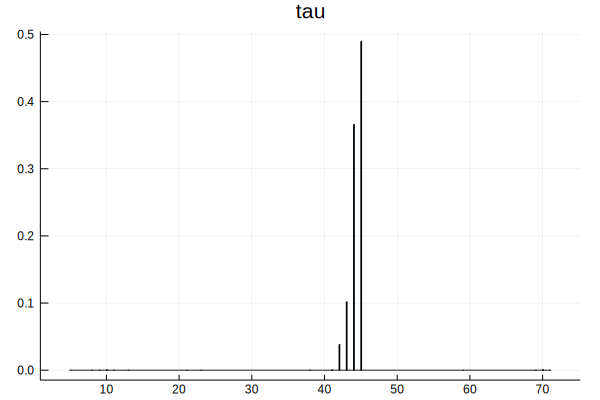

In [24]:
histogram(vec(sim1[:, :tau, :].value), normalize = :probability, title = "tau", label = "")

### 受信メッセージ数とその期待値を表示する

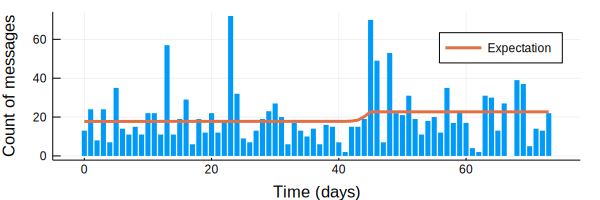

In [25]:
bar(0:N-1, count_data.messages, label = "", size = [600, 200],
    linecolor = :transparent,
    xlabel = "Time (days)", ylabel = "Count of messages")
plot!(0:N-1, vec(mean(sim1[:, :lambda, :].value, dims=[1, 3])), linewidth = 3, label = "Expectation")

### 実際に二つの$\lambda$は統計的に異なっているのか？
事後分布から得られたサンプル

In [26]:
lambda1_sample = sim1[:, :lambda1, :].value
lambda2_sample = sim1[:, :lambda2, :].value

3000×1×3 Array{Float64,3}:
[:, :, 1] =
 22.122026451897856
 22.27108767816746 
 22.27108767816746 
 23.077569627687957
 22.35129629982776 
 22.04798256159689 
 22.39716028179219 
 23.044551271288473
 22.230600524350702
 23.065065160868663
 23.06500567703682 
 21.784019049486652
 23.345184220385235
  ⋮                
 24.971279696936897
 21.741650049481997
 22.49140039433157 
 22.49140039433157 
 23.837912865641783
 22.320693877272753
 22.646212920114575
 22.646212920114575
 22.06289072715093 
 22.077277568410125
 22.077277568410125
 22.077277568410125

[:, :, 2] =
 24.952393186252788
 23.399139055670084
 21.53823936886544 
 21.82253490826531 
 22.45956035915865 
 23.61648562835872 
 22.9466761439458  
 22.094959288735872
 21.805779074097245
 22.109011730688874
 23.001341697977487
 23.386710752533258
 22.164411537381856
  ⋮                
 21.60282075002095 
 24.394555482931786
 24.810917751892333
 24.810917751892333
 22.667514146384182
 23.37095034460404 
 21.78808513694875 
 22.8596

$\lambda_1 < \lambda_2$となったサンプル数

In [27]:
sum(lambda1_sample .< lambda2_sample)

8989

全サンプル数

In [28]:
length(lambda1_sample)

9000

$\lambda_1$が$\lambda_2$となる確率$p(\lambda_1 < \lambda_2 \mid \text{data})$を求める。結果はほとんど1になる。

In [29]:
mean(lambda1_sample .< lambda2_sample)

0.9987777777777778

$\lambda_1$と$\lambda_2$の値が1, 2, 5, 10より大きく異なっている確率を求めよう。

In [30]:
for d in [1, 2, 5, 10]
    println("The probability the difference is larger than ", d, " : ", mean(abs.(lambda1_sample .- lambda2_sample) .> d))
end

The probability the difference is larger than 1 : 0.9996666666666667
The probability the difference is larger than 2 : 0.9963333333333333
The probability the difference is larger than 5 : 0.47155555555555556
The probability the difference is larger than 10 : 0.0


### 演習問題1. $\lambda_1$と$\lambda_2$の事後分布の平均を求める。

In [31]:
println(mean(sim1[:, :lambda1, :].value))
println(mean(sim1[:, :lambda2, :].value))

17.759159245898424
22.674104360325032


### 演習問題2. メッセージ受信数の増加数のヒストリグラムを作成し、期待値を求める。

In [32]:
relative_increase_samples = (lambda2_sample - lambda1_sample) ./ lambda1_sample

3000×1×3 Array{Float64,3}:
[:, :, 1] =
 0.24983531799322753
 0.23980576267592715
 0.20333822122783604
 0.25105443148988466
 0.2339236284955079 
 0.21717891787873464
 0.3613126742594505 
 0.30179597656642676
 0.16615976339725308
 0.2743081694934804 
 0.26464419931842076
 0.18727314002378168
 0.2824436539021704 
 ⋮                  
 0.44034928121934   
 0.25406348418479924
 0.26153571006640336
 0.2686411716082667 
 0.3445920296801658 
 0.38673872121682734
 0.2614234026278724 
 0.3049426377615872 
 0.20427183310226182
 0.19545712339721738
 0.24934775735636805
 0.27860762809705125

[:, :, 2] =
 0.40675549362132596
 0.27001429305671326
 0.23025058163085638
 0.24648936265245353
 0.28726632610691777
 0.3540169614930048 
 0.3262256492513227 
 0.3011492317745127 
 0.21846992189351871
 0.21643615576462868
 0.2630260893173574 
 0.33341749216193844
 0.14852843406207294
 ⋮                  
 0.2443529687688868 
 0.4051608300714181 
 0.3988782365887406 
 0.4228345201829226 
 0.24577268894079243
 0.

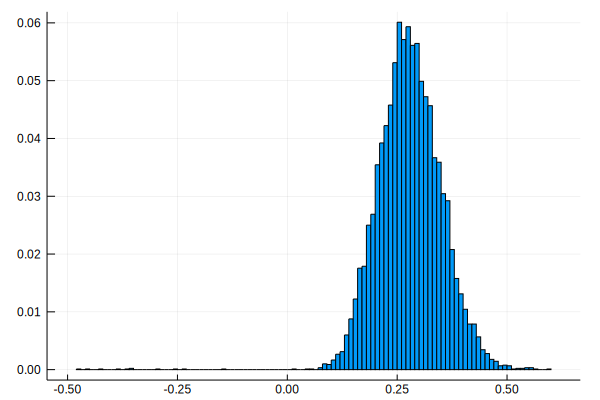

In [33]:
histogram(vec(relative_increase_samples), normalize = :probability, label = "")

In [34]:
mean(relative_increase_samples)

0.2785538456872619

### 演習問題3. $\tau$が45よりも小さいという情報が与えられた場合の$\lambda_1$の平均を求める。

In [35]:
mean(lambda1_sample[sim1[:, :tau, :].value .< 45])

17.75838867931658

### 二つの変化点への拡張
変化点が一つではなく、二つの場合の拡張を考えてみよう。
\begin{align}
\lambda_t = \left\{ \begin{array}{ll}
\lambda_1 & \text{if}\ t < \tau_1,\\
\lambda_2 & \text{if}\ \tau_1 \le t < \tau_2,\\
\lambda_3 & \text{if}\ t \ge \tau_2. 
\end{array} \right.
\end{align}
となっていると仮定する。
事前分布は、
\begin{align}
\lambda_1 & \sim \text{Exp}(\alpha) \\
\lambda_2 & \sim \text{Exp}(\alpha) \\
\lambda_3 & \sim \text{Exp}(\alpha) \\
\tau_1 & \sim \text{DiscreteUniform}(0,N-1) \\
\tau_2 & \sim \text{DiscreteUniform}(\tau_1,N)
\end{align}

In [57]:
model2 = Model(
    
    obs = Stochastic(1,
        (lambda, N) ->
            UnivariateDistribution[Poisson(lambda[i]) for i in 1:N],
        false
    ),
    
    lambda = Logical(1, 
        (lambda1, lambda2, lambda3, tau1, tau2, N) -> 
            (out = fill(lambda1, N);
            i1 = Int64(tau1.value) + 1; # Juliaは1-indexingのため
            i2 = Int64(tau2.value) + 1;
            out[i1:end] .= lambda2;
            out[i2:end] .= lambda3;
            out),
            false,
        ),
    
    lambda1 = Stochastic(theta -> Exponential(theta)),
    lambda2 = Stochastic(theta -> Exponential(theta)),
    lambda3 = Stochastic(theta -> Exponential(theta)),
    
    tau1 = Stochastic(N -> DiscreteUniform(0, N-1)),
    tau2 = Stochastic((tau1, N) -> DiscreteUniform(tau1, N)),
)

Object of type "Model"
-------------------------------------------------------------------------------
lambda:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
lambda1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
tau1:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
tau2:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
lambda3:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
lambda2:
A monitored node of type "ScalarStocha

In [58]:
inits2 = [
    Dict{Symbol, Any}(
        :obs => count_data.messages,
        :lambda1 => theta,
        :lambda2 => theta,
        :lambda3 => theta,
        :tau1 => 1,
        :tau2 => N,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)
 Dict(:lambda1=>19.7432,:tau1=>1,:tau2=>74,:obs=>[13.0, 24.0, 8.0, 24.0, 7.0, 35.0, 14.0, 11.0, 15.0, 11.0  …  30.0, 13.0, 27.0, 0.0, 39.0, 37.0, 5.0, 14.0, 13.0, 22.0],:lambda3=>19.7432,:lambda2=>19.7432)

In [71]:
scheme2 = [AMWG([:lambda1, :lambda2, :lambda3], 1.0), DGS([:tau1, :tau2])]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:lambda1, :lambda2, :lambda3]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.DSTune{Function}}"
Sampling Block Nodes:
Symbol[:tau1, :tau2]

CodeInfo(
1 ─ %1 = π (##238#241(Box(Symbol[:tau1, :tau2])), Const(##238#241(Box(Symbol[:tau1, :tau2])), false))
│   %2 = (%1)(model, block)::Const(nothing, false)
└──      return %2
) => Nothing
                                                                                                                                                     

In [72]:
setsamplers!(model2, scheme2)
sim2 = mcmc(model2, data0, inits2, 40000, burnin = 10000, thin = 3, chains = 3)

MCMC Simulation of 40000 Iterations x 3 Chains...

      From worker 4:	Chain 2:   0% [0:03:10 of 0:03:10 remaining]
      From worker 3:	Chain 3:   0% [0:03:16 of 0:03:16 remaining]
      From worker 2:	Chain 1:   0% [0:03:26 of 0:03:26 remaining]
      From worker 2:	Chain 1:  10% [0:01:52 of 0:02:05 remaining]
      From worker 4:	Chain 2:  10% [0:01:53 of 0:02:05 remaining]
      From worker 3:	Chain 3:  10% [0:01:57 of 0:02:10 remaining]
      From worker 2:	Chain 1:  20% [0:01:41 of 0:02:06 remaining]
      From worker 4:	Chain 2:  20% [0:01:42 of 0:02:07 remaining]
      From worker 3:	Chain 3:  20% [0:01:44 of 0:02:10 remaining]
      From worker 4:	Chain 2:  30% [0:01:29 of 0:02:07 remaining]
      From worker 2:	Chain 1:  30% [0:01:29 of 0:02:07 remaining]
      From worker 3:	Chain 3:  30% [0:01:30 of 0:02:09 remaining]
      From worker 2:	Chain 1:  40% [0:01:16 of 0:02:07 remaining]
      From worker 4:	Chain 2:  40% [0:01:16 of 0:02:07 remaining]
      From worker 3:	Chai

Object of type "ModelChains"

Iterations = 10003:40000
Thinning interval = 3
Chains = 1,2,3
Samples per chain = 10000

[45.0 47.0 … 51.0944 17.0748; 45.0 47.0 … 55.5868 17.0748; … ; 45.0 47.0 … 55.7924 16.7172; 45.0 47.0 … 56.8194 17.1971]

[45.0 47.0 … 54.0933 17.4372; 45.0 47.0 … 51.6294 17.4372; … ; 45.0 47.0 … 60.9099 18.6808; 45.0 47.0 … 60.6595 18.6808]

[45.0 47.0 … 57.3636 18.1835; 45.0 47.0 … 60.6953 16.878; … ; 45.0 47.0 … 65.4848 17.0166; 45.0 47.0 … 57.4376 17.0166]

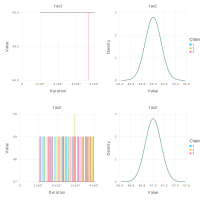

In [73]:
p2 = Mamba.plot(sim2[:, [:tau1, :tau2], :], legend = true)
Mamba.draw(p2, nrow = 2, ncol = 2)

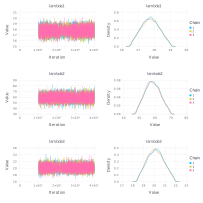

In [74]:
p2 = Mamba.plot(sim2[:, [:lambda1, :lambda2, :lambda3], :], legend = true)
Mamba.draw(p2, nrow = 3, ncol = 2)